# Optical Flow Estimation Demo

This notebook demonstrates the Python optical flow package, a reimplementation of
Sun, Roth & Black's "Secrets of Optical Flow Estimation and Their Principles" (CVPR 2010).

## Setup

Make sure the package is installed:
```bash
cd flow_code_python
pip install -e .
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time

# Import the optical flow package
from optical_flow import estimate_flow, flow_to_color, plot_flow, flow_angular_error
from optical_flow.io.flo_io import read_flo, write_flo, read_flow_file
from optical_flow.methods.config import load_of_method
from optical_flow.robust.robust_function import RobustFunction
from optical_flow.utils.image_processing import fspecial_gaussian

# For inline plots
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

## 1. Load Test Images

We use the Middlebury RubberWhale sequence, which includes ground truth flow.

Image shape: (388, 584, 3)
Image dtype: float64
Flow shape: (388, 584)


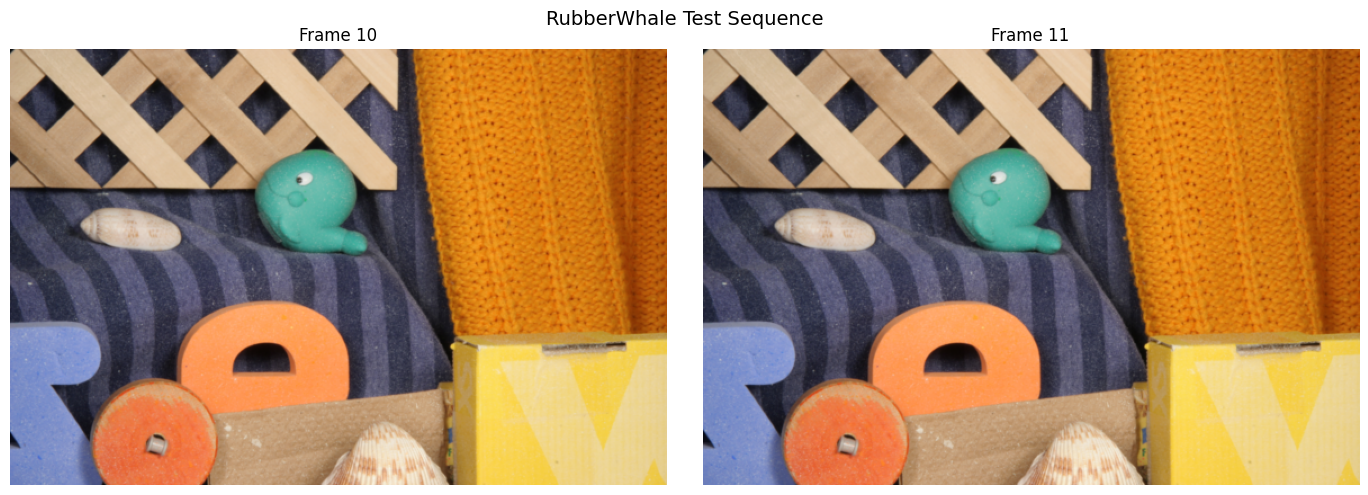

In [2]:
# Load the RubberWhale sequence
data_dir = os.path.join('..', 'data')
im1, im2, tu, tv = read_flow_file('RubberWhale', 10, data_dir=data_dir)

print(f'Image shape: {im1.shape}')
print(f'Image dtype: {im1.dtype}')
print(f'Flow shape: {tu.shape}')

# Display the image pair
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(im1.astype(np.uint8))
axes[0].set_title('Frame 10')
axes[0].axis('off')
axes[1].imshow(im2.astype(np.uint8))
axes[1].set_title('Frame 11')
axes[1].axis('off')
plt.suptitle('RubberWhale Test Sequence', fontsize=14)
plt.tight_layout()
plt.show()

## 2. Visualize Ground Truth Flow

The ground truth flow is displayed using the Middlebury color coding scheme.

In [3]:
# Combine ground truth into (H, W, 2) array
gt_flow = np.stack([tu, tv], axis=2)

# Visualize with different styles
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plot_flow(gt_flow, style='color', ax=axes[0, 0])
axes[0, 0].set_title('Ground Truth (Middlebury Color)')

plot_flow(gt_flow, style='quiver', ax=axes[0, 1], step=12)
axes[0, 1].set_title('Ground Truth (Quiver)')

plot_flow(gt_flow, style='magnitude', ax=axes[1, 0])
axes[1, 0].set_title('Ground Truth (Magnitude)')

plot_flow(gt_flow, style='hsv', ax=axes[1, 1])
axes[1, 1].set_title('Ground Truth (HSV)')

plt.suptitle('Ground Truth Flow Visualization', fontsize=14)
plt.tight_layout()
plt.show()

## 3. Run Horn-Schunck Optical Flow

The simplest method: quadratic regularization with a Laplacian spatial term.

Running Horn-Schunck...
Pyramid level: 5
  Iteration: 1  (norm: 1.842419)
  Iteration: 2  (norm: 0.307484)
  Iteration: 3  (norm: 0.301695)
  Iteration: 4  (norm: 0.292543)
  Iteration: 5  (norm: 0.297882)
  Iteration: 6  (norm: 0.292663)
  Iteration: 7  (norm: 0.297866)
  Iteration: 8  (norm: 0.292665)
  Iteration: 9  (norm: 0.297866)
  Iteration: 10  (norm: 0.292665)
Pyramid level: 4
  Iteration: 1  (norm: 4.506012)
  Iteration: 2  (norm: 1.113458)
  Iteration: 3  (norm: 0.925447)
  Iteration: 4  (norm: 0.920069)
  Iteration: 5  (norm: 0.913739)
  Iteration: 6  (norm: 0.914161)
  Iteration: 7  (norm: 0.919660)
  Iteration: 8  (norm: 0.915135)
  Iteration: 9  (norm: 0.912711)
  Iteration: 10  (norm: 0.921133)
Pyramid level: 3
  Iteration: 1  (norm: 14.686715)
  Iteration: 2  (norm: 4.644671)
  Iteration: 3  (norm: 4.126694)
  Iteration: 4  (norm: 4.043206)
  Iteration: 5  (norm: 4.045740)
  Iteration: 6  (norm: 4.005453)
  Iteration: 7  (norm: 4.039955)
  Iteration: 8  (norm: 4.038271

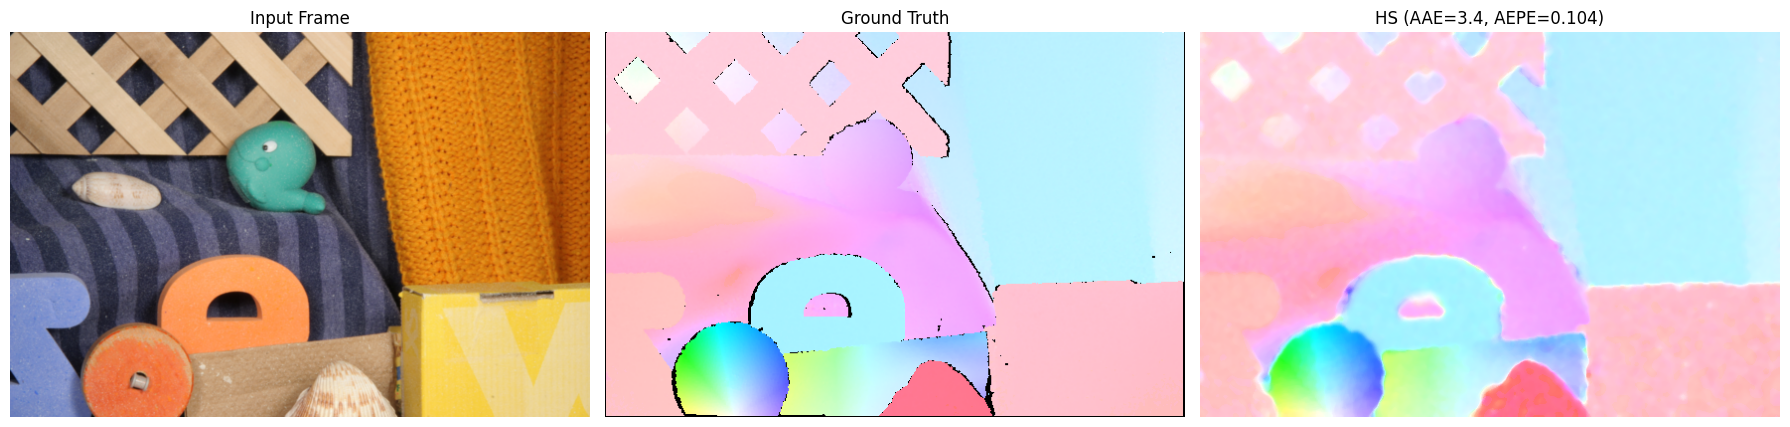

In [4]:
# Run HS with texture decomposition
print('Running Horn-Schunck...')
t0 = time.time()
uv_hs = estimate_flow(im1, im2, method='hs')
t_hs = time.time() - t0
print(f'Elapsed: {t_hs:.1f}s')

# Evaluate
aae_hs, std_hs, aepe_hs = flow_angular_error(tu, tv, uv_hs[:,:,0], uv_hs[:,:,1])
print(f'AAE: {aae_hs:.2f} degrees (std: {std_hs:.2f})')
print(f'AEPE: {aepe_hs:.3f} pixels')

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(im1.astype(np.uint8))
axes[0].set_title('Input Frame')
axes[0].axis('off')

plot_flow(gt_flow, style='color', ax=axes[1])
axes[1].set_title('Ground Truth')

plot_flow(uv_hs, style='color', ax=axes[2])
axes[2].set_title(f'HS (AAE={aae_hs:.1f}, AEPE={aepe_hs:.3f})')

plt.tight_layout()
plt.show()

## 4. Run Black-Anandan Optical Flow

Uses robust (lorentzian) penalties with Graduated Non-Convexity (GNC) optimization.

Running Black-Anandan...
GNC stage 1 finished, 1.30 minutes passed
GNC stage 2 finished, 2.98 minutes passed
GNC stage 3 finished, 4.58 minutes passed
Elapsed: 275.6s
AAE: 2.81 degrees (std: 9.99)
AEPE: 0.086 pixels


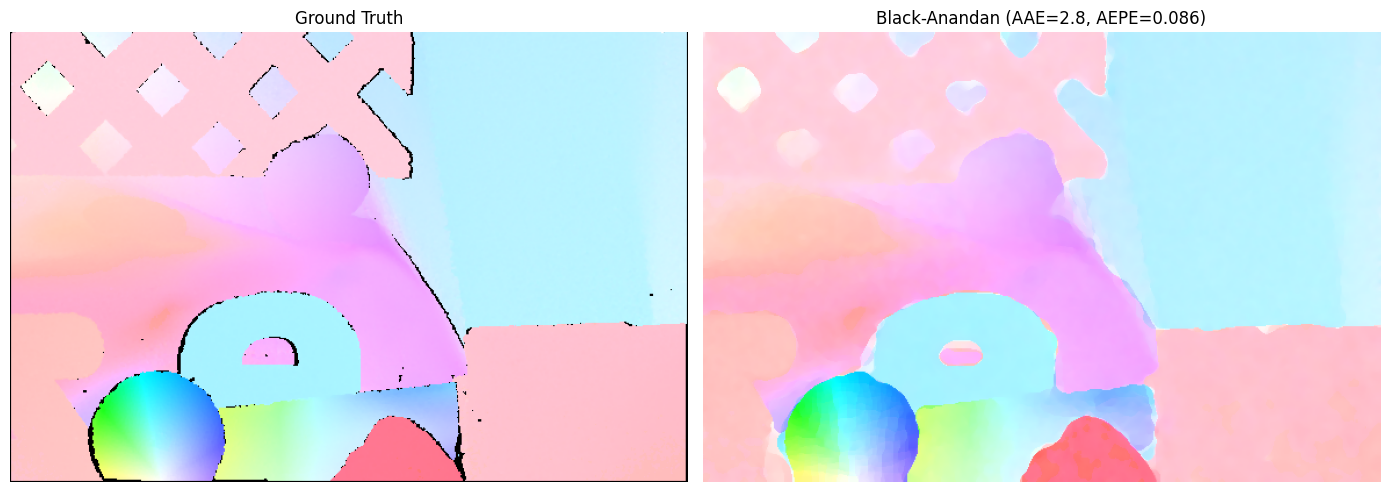

In [5]:
print('Running Black-Anandan...')
t0 = time.time()
uv_ba = estimate_flow(im1, im2, method='ba')
t_ba = time.time() - t0
print(f'Elapsed: {t_ba:.1f}s')

aae_ba, std_ba, aepe_ba = flow_angular_error(tu, tv, uv_ba[:,:,0], uv_ba[:,:,1])
print(f'AAE: {aae_ba:.2f} degrees (std: {std_ba:.2f})')
print(f'AEPE: {aepe_ba:.3f} pixels')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_flow(gt_flow, style='color', ax=axes[0])
axes[0].set_title('Ground Truth')
plot_flow(uv_ba, style='color', ax=axes[1])
axes[1].set_title(f'Black-Anandan (AAE={aae_ba:.1f}, AEPE={aepe_ba:.3f})')
plt.tight_layout()
plt.show()

## 5. Compare All Methods

Run several methods and compare their accuracy.

In [6]:
methods_to_test = [
    ('hs-brightness', 'HS (brightness)'),
    ('hs', 'HS (texture)'),
    ('ba', 'Black-Anandan'),
    ('classic-c', 'Classic-C'),
]

results = []
flows = {}

for method_name, label in methods_to_test:
    print(f'Running {label}...')
    t0 = time.time()
    uv = estimate_flow(im1, im2, method=method_name)
    elapsed = time.time() - t0
    
    aae, std_ae, aepe = flow_angular_error(tu, tv, uv[:,:,0], uv[:,:,1])
    results.append({
        'method': label,
        'aae': aae,
        'std_ae': std_ae,
        'aepe': aepe,
        'time': elapsed
    })
    flows[label] = uv
    print(f'  AAE={aae:.2f}, AEPE={aepe:.3f}, Time={elapsed:.1f}s')

# Print comparison table
print('\n' + '='*65)
print(f'{"Method":<25} {"AAE (deg)":>10} {"AEPE (px)":>10} {"Time (s)":>10}')
print('-'*65)
for r in results:
    print(f'{r["method"]:<25} {r["aae"]:>10.2f} {r["aepe"]:>10.3f} {r["time"]:>10.1f}')
print('='*65)

Running HS (brightness)...
  AAE=4.58, AEPE=0.142, Time=75.9s
Running HS (texture)...
Pyramid level: 5
  Iteration: 1  (norm: 1.842419)
  Iteration: 2  (norm: 0.307484)
  Iteration: 3  (norm: 0.301695)
  Iteration: 4  (norm: 0.292543)
  Iteration: 5  (norm: 0.297882)
  Iteration: 6  (norm: 0.292663)
  Iteration: 7  (norm: 0.297866)
  Iteration: 8  (norm: 0.292665)
  Iteration: 9  (norm: 0.297866)
  Iteration: 10  (norm: 0.292665)
Pyramid level: 4
  Iteration: 1  (norm: 4.506012)
  Iteration: 2  (norm: 1.113458)
  Iteration: 3  (norm: 0.925447)
  Iteration: 4  (norm: 0.920069)
  Iteration: 5  (norm: 0.913739)
  Iteration: 6  (norm: 0.914161)
  Iteration: 7  (norm: 0.919660)
  Iteration: 8  (norm: 0.915135)
  Iteration: 9  (norm: 0.912711)
  Iteration: 10  (norm: 0.921133)
Pyramid level: 3
  Iteration: 1  (norm: 14.686715)
  Iteration: 2  (norm: 4.644671)
  Iteration: 3  (norm: 4.126694)
  Iteration: 4  (norm: 4.043206)
  Iteration: 5  (norm: 4.045740)
  Iteration: 6  (norm: 4.005453)
  

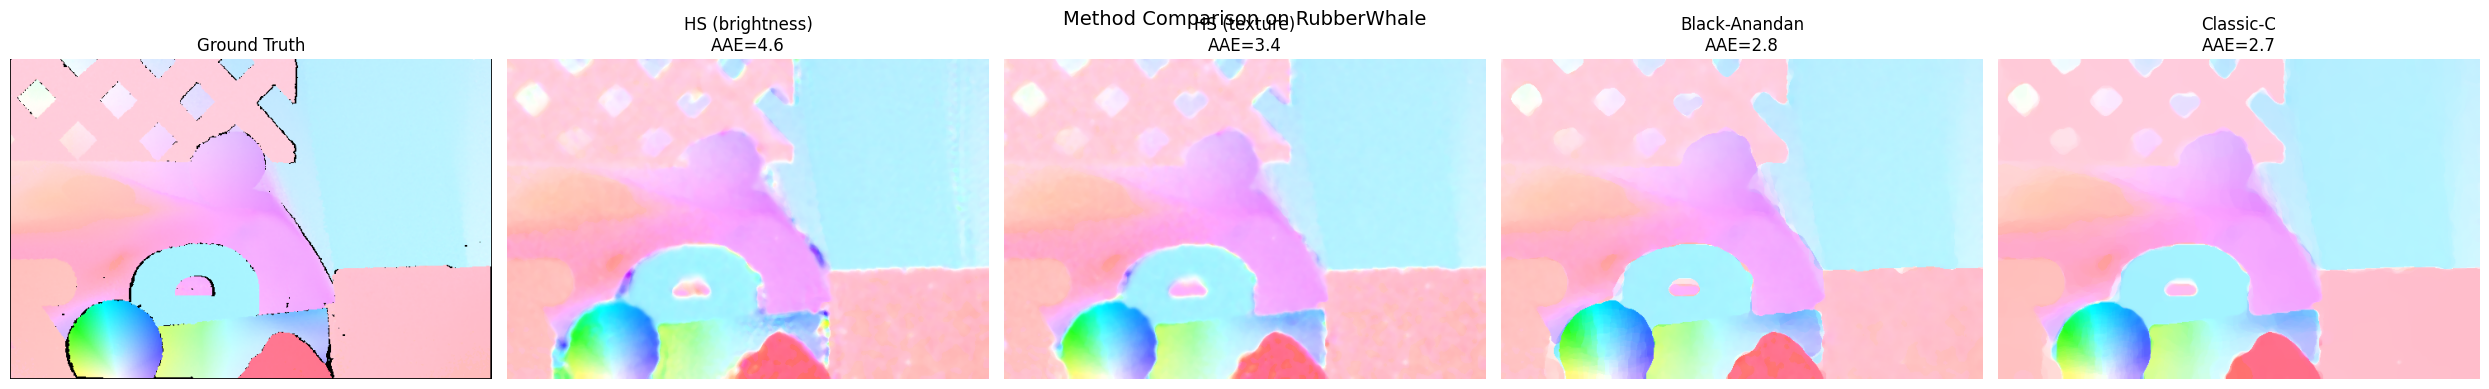

In [7]:
# Visual comparison
n_methods = len(flows)
fig, axes = plt.subplots(1, n_methods + 1, figsize=(5 * (n_methods + 1), 4))

plot_flow(gt_flow, style='color', ax=axes[0])
axes[0].set_title('Ground Truth')

for i, (label, uv) in enumerate(flows.items()):
    r = results[i]
    plot_flow(uv, style='color', ax=axes[i + 1])
    axes[i + 1].set_title(f'{label}\nAAE={r["aae"]:.1f}')

plt.suptitle('Method Comparison on RubberWhale', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Robust Penalty Functions

The package implements several robust penalty functions used for data and spatial terms.

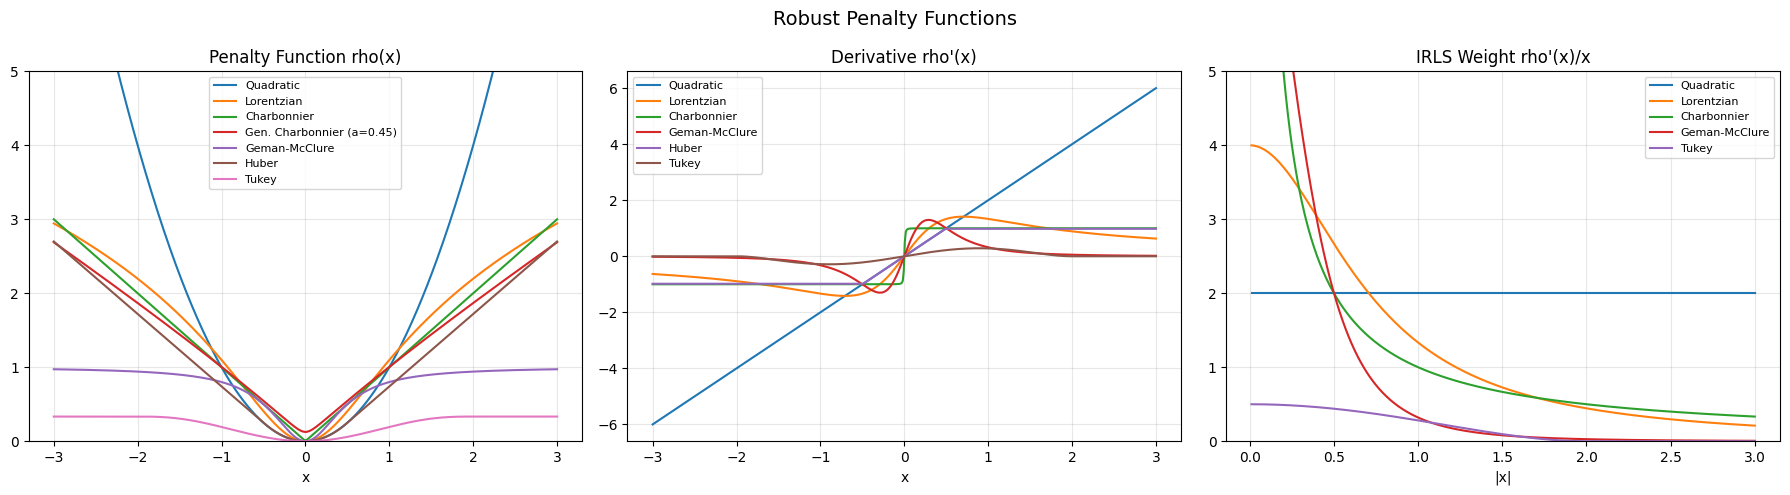

In [8]:
from optical_flow.robust.penalties import (
    quadratic, lorentzian, charbonnier, generalized_charbonnier,
    geman_mcclure, huber, tukey
)

x = np.linspace(-3, 3, 500)

penalties = [
    ('Quadratic', lambda x: quadratic(x, 1.0, 0)),
    ('Lorentzian', lambda x: lorentzian(x, 0.5, 0)),
    ('Charbonnier', lambda x: charbonnier(x, 0.1, 0)),
    ('Gen. Charbonnier (a=0.45)', lambda x: generalized_charbonnier(x, [0.1, 0.45], 0)),
    ('Geman-McClure', lambda x: geman_mcclure(x, 0.5, 0)),
    ('Huber', lambda x: huber(x, 0.7, 0)),
    ('Tukey', lambda x: tukey(x, 2.0, 0)),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot penalty values
for name, func in penalties:
    axes[0].plot(x, func(x), label=name)
axes[0].set_title('Penalty Function rho(x)')
axes[0].set_xlabel('x')
axes[0].legend(fontsize=8)
axes[0].set_ylim(0, 5)
axes[0].grid(True, alpha=0.3)

# Plot derivatives
derivs = [
    ('Quadratic', lambda x: quadratic(x, 1.0, 1)),
    ('Lorentzian', lambda x: lorentzian(x, 0.5, 1)),
    ('Charbonnier', lambda x: charbonnier(x, 0.1, 1)),
    ('Geman-McClure', lambda x: geman_mcclure(x, 0.5, 1)),
    ('Huber', lambda x: huber(x, 0.7, 1)),
    ('Tukey', lambda x: tukey(x, 2.0, 1)),
]
for name, func in derivs:
    axes[1].plot(x, func(x), label=name)
axes[1].set_title("Derivative rho'(x)")
axes[1].set_xlabel('x')
axes[1].legend(fontsize=8)
axes[1].grid(True, alpha=0.3)

# Plot IRLS weights
x_pos = np.linspace(0.01, 3, 500)  # Avoid division by zero
weights = [
    ('Quadratic', lambda x: quadratic(x, 1.0, 2)),
    ('Lorentzian', lambda x: lorentzian(x, 0.5, 2)),
    ('Charbonnier', lambda x: charbonnier(x, 0.1, 2)),
    ('Geman-McClure', lambda x: geman_mcclure(x, 0.5, 2)),
    ('Tukey', lambda x: tukey(x, 2.0, 2)),
]
for name, func in weights:
    axes[2].plot(x_pos, func(x_pos), label=name)
axes[2].set_title("IRLS Weight rho'(x)/x")
axes[2].set_xlabel('|x|')
axes[2].legend(fontsize=8)
axes[2].set_ylim(0, 5)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Robust Penalty Functions', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Image Pyramid Visualization

The coarse-to-fine estimation uses a Gaussian image pyramid.

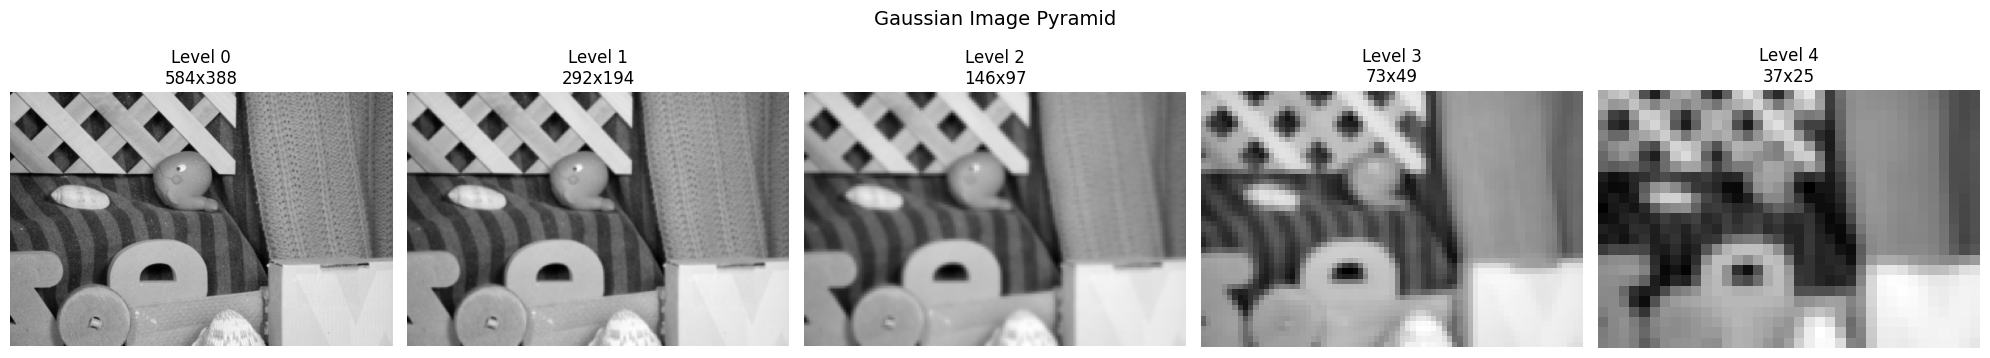

In [9]:
from optical_flow.utils.pyramid import compute_image_pyramid

# Build pyramid
gray1 = 0.2989 * im1[:,:,0] + 0.5870 * im1[:,:,1] + 0.1140 * im1[:,:,2]
sigma = np.sqrt(2.0) / np.sqrt(2)
ksize = int(2 * round(1.5 * sigma) + 1)
f = fspecial_gaussian(ksize, sigma)

pyr = compute_image_pyramid(gray1, f, n_levels=5, ratio=0.5)

fig, axes = plt.subplots(1, len(pyr), figsize=(20, 4))
for i, level in enumerate(pyr):
    axes[i].imshow(level, cmap='gray')
    axes[i].set_title(f'Level {i}\n{level.shape[1]}x{level.shape[0]}')
    axes[i].axis('off')

plt.suptitle('Gaussian Image Pyramid', fontsize=14)
plt.tight_layout()
plt.show()

## 8. Flow I/O Round-Trip

Demonstrate writing and reading .flo files.

Max difference after round-trip: 0.0
Round-trip exact: True


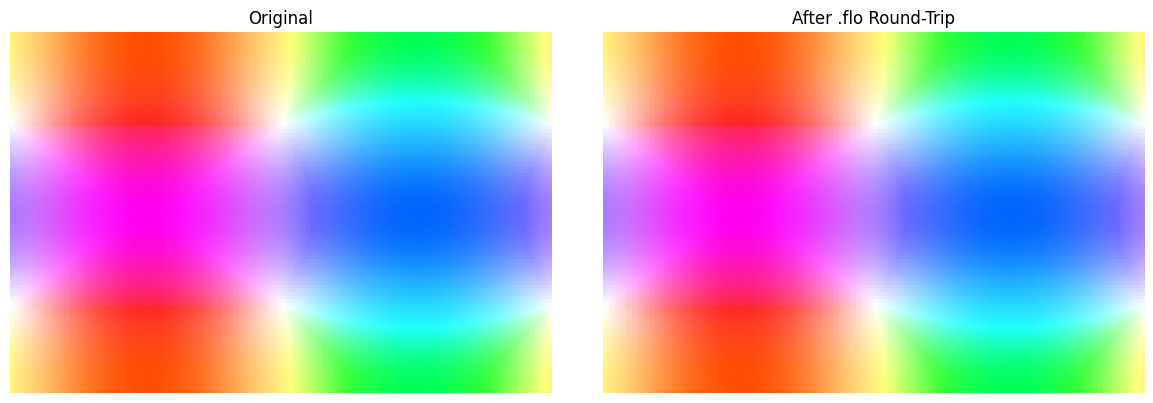

In [10]:
import tempfile

# Create a synthetic flow field
H, W = 100, 150
y, x = np.mgrid[0:H, 0:W].astype(float)
flow_synth = np.zeros((H, W, 2))
flow_synth[:,:,0] = np.sin(2 * np.pi * x / W) * 5  # Horizontal sinusoidal
flow_synth[:,:,1] = np.cos(2 * np.pi * y / H) * 3  # Vertical cosinusoidal

# Write and read back
with tempfile.NamedTemporaryFile(suffix='.flo', delete=False) as f:
    flo_path = f.name

write_flo(flow_synth, flo_path)
flow_read = read_flo(flo_path)

# Verify round-trip
max_diff = np.max(np.abs(flow_synth.astype(np.float32) - flow_read))
print(f'Max difference after round-trip: {max_diff}')
print(f'Round-trip exact: {max_diff == 0}')

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_flow(flow_synth, style='color', ax=axes[0])
axes[0].set_title('Original')
plot_flow(flow_read, style='color', ax=axes[1])
axes[1].set_title('After .flo Round-Trip')
plt.tight_layout()
plt.show()

# Clean up
os.unlink(flo_path)

## 9. Parameter Sensitivity

Explore how the regularization parameter lambda affects the result.

Running HS-brightness with lambda=10...
Running HS-brightness with lambda=40...
Running HS-brightness with lambda=80...
Running HS-brightness with lambda=200...


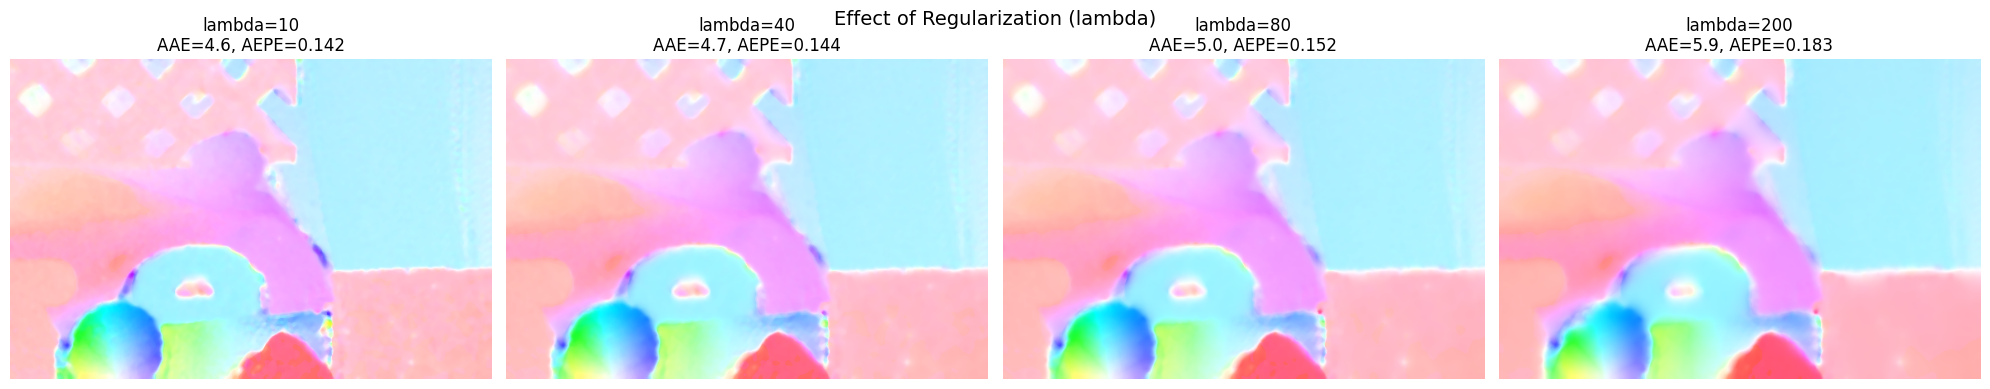

In [11]:
lambdas = [10, 40, 80, 200]

fig, axes = plt.subplots(1, len(lambdas), figsize=(5 * len(lambdas), 4))

for i, lam in enumerate(lambdas):
    print(f'Running HS-brightness with lambda={lam}...')
    uv = estimate_flow(im1, im2, method='hs-brightness',
                      params={'lambda': lam, 'lambda_q': lam,
                              'max_iters': 5, 'pyramid_levels': 3})
    aae, _, aepe = flow_angular_error(tu, tv, uv[:,:,0], uv[:,:,1])
    plot_flow(uv, style='color', ax=axes[i])
    axes[i].set_title(f'lambda={lam}\nAAE={aae:.1f}, AEPE={aepe:.3f}')

plt.suptitle('Effect of Regularization (lambda)', fontsize=14)
plt.tight_layout()
plt.show()

## 10. Texture Decomposition Effect

Compare brightness constancy vs texture constancy (ROF structure-texture decomposition).

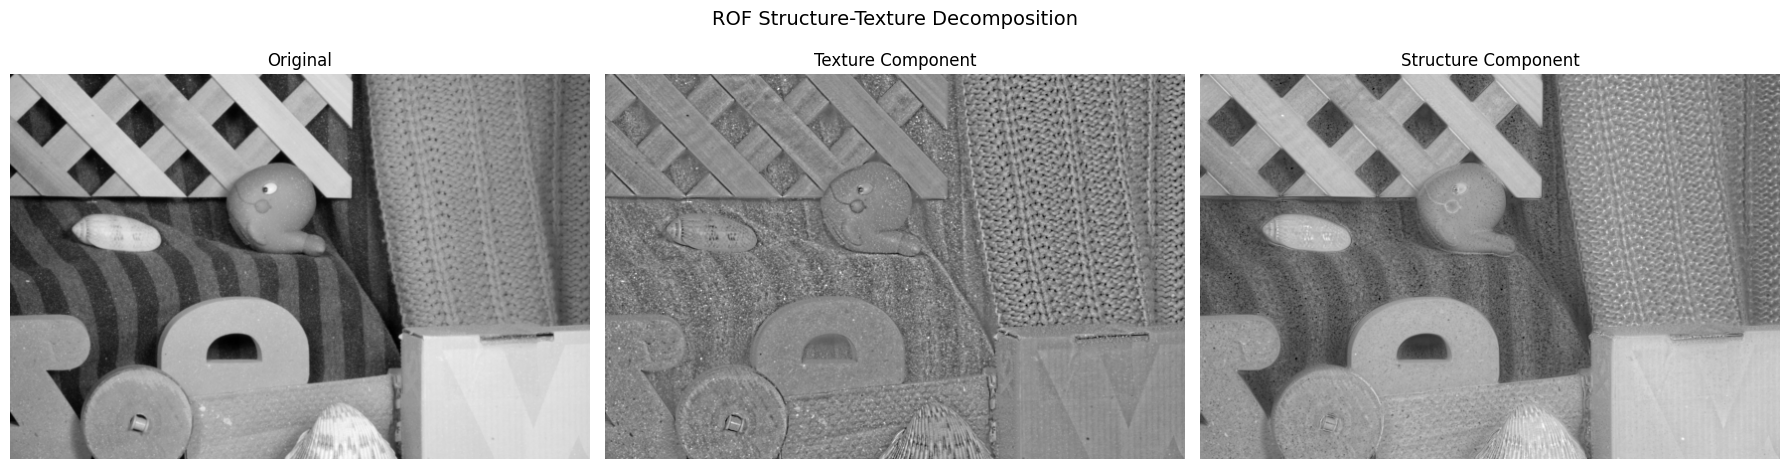

In [12]:
from optical_flow.utils.image_processing import structure_texture_decomposition_rof

# Show texture decomposition
gray1 = 0.2989 * im1[:,:,0] + 0.5870 * im1[:,:,1] + 0.1140 * im1[:,:,2]
texture = structure_texture_decomposition_rof(gray1, theta=1.0/8, n_iters=100, alp=0.95)
structure = gray1 - texture / 0.95  # Approximate structure

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].imshow(gray1, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(texture, cmap='gray')
axes[1].set_title('Texture Component')
axes[1].axis('off')

axes[2].imshow(structure, cmap='gray')
axes[2].set_title('Structure Component')
axes[2].axis('off')

plt.suptitle('ROF Structure-Texture Decomposition', fontsize=14)
plt.tight_layout()
plt.show()

Running HS with brightness constancy...
Running HS with texture constancy...
Pyramid level: 5
  Iteration: 1  (norm: 1.842419)
  Iteration: 2  (norm: 0.307484)
  Iteration: 3  (norm: 0.301695)
  Iteration: 4  (norm: 0.292543)
  Iteration: 5  (norm: 0.297882)
  Iteration: 6  (norm: 0.292663)
  Iteration: 7  (norm: 0.297866)
  Iteration: 8  (norm: 0.292665)
  Iteration: 9  (norm: 0.297866)
  Iteration: 10  (norm: 0.292665)
Pyramid level: 4
  Iteration: 1  (norm: 4.506012)
  Iteration: 2  (norm: 1.113458)
  Iteration: 3  (norm: 0.925447)
  Iteration: 4  (norm: 0.920069)
  Iteration: 5  (norm: 0.913739)
  Iteration: 6  (norm: 0.914161)
  Iteration: 7  (norm: 0.919660)
  Iteration: 8  (norm: 0.915135)
  Iteration: 9  (norm: 0.912711)
  Iteration: 10  (norm: 0.921133)
Pyramid level: 3
  Iteration: 1  (norm: 14.686715)
  Iteration: 2  (norm: 4.644671)
  Iteration: 3  (norm: 4.126694)
  Iteration: 4  (norm: 4.043206)
  Iteration: 5  (norm: 4.045740)
  Iteration: 6  (norm: 4.005453)
  Iteration

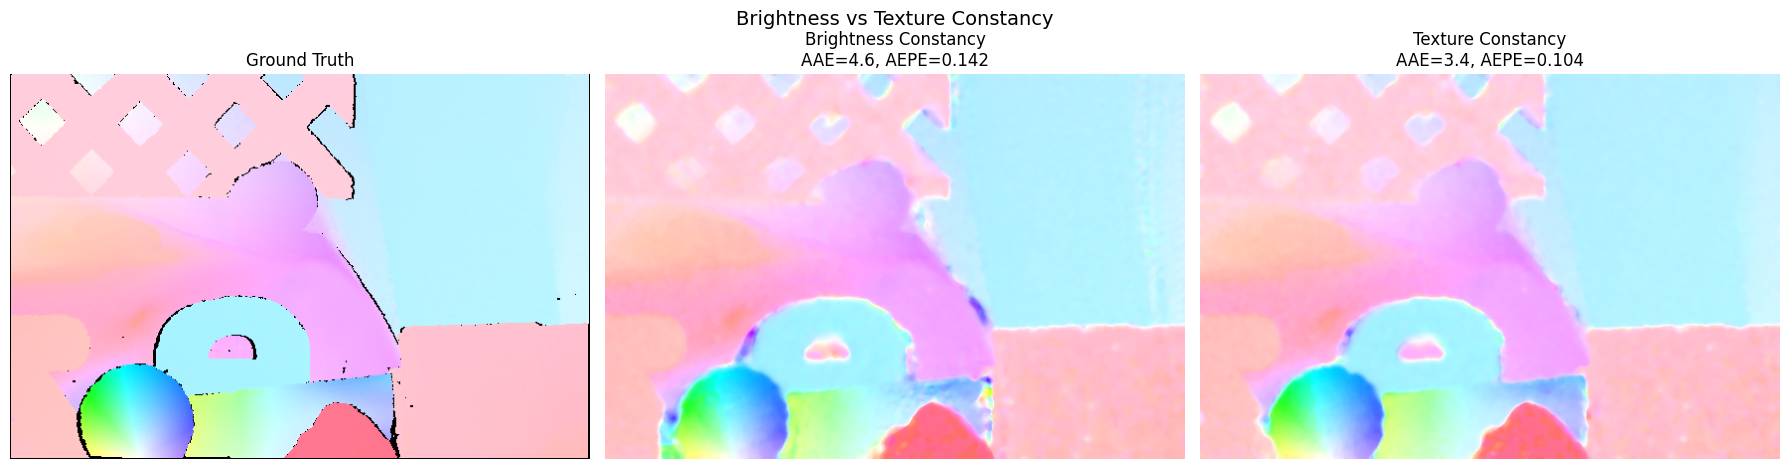


Brightness: AAE=4.58, AEPE=0.142
Texture:    AAE=3.36, AEPE=0.104


In [13]:
# Compare brightness vs texture constancy
print('Running HS with brightness constancy...')
uv_bright = estimate_flow(im1, im2, method='hs-brightness',
                          params={'max_iters': 5})
aae_b, _, aepe_b = flow_angular_error(tu, tv, uv_bright[:,:,0], uv_bright[:,:,1])

print('Running HS with texture constancy...')
uv_tex = estimate_flow(im1, im2, method='hs',
                       params={'max_iters': 5})
aae_t, _, aepe_t = flow_angular_error(tu, tv, uv_tex[:,:,0], uv_tex[:,:,1])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
plot_flow(gt_flow, style='color', ax=axes[0])
axes[0].set_title('Ground Truth')

plot_flow(uv_bright, style='color', ax=axes[1])
axes[1].set_title(f'Brightness Constancy\nAAE={aae_b:.1f}, AEPE={aepe_b:.3f}')

plot_flow(uv_tex, style='color', ax=axes[2])
axes[2].set_title(f'Texture Constancy\nAAE={aae_t:.1f}, AEPE={aepe_t:.3f}')

plt.suptitle('Brightness vs Texture Constancy', fontsize=14)
plt.tight_layout()
plt.show()

print(f'\nBrightness: AAE={aae_b:.2f}, AEPE={aepe_b:.3f}')
print(f'Texture:    AAE={aae_t:.2f}, AEPE={aepe_t:.3f}')

## Summary

This notebook demonstrated:

1. Loading Middlebury test sequences with ground truth
2. Running multiple optical flow methods (HS, BA, Classic-C)
3. Evaluating accuracy with AAE and AEPE metrics
4. Visualizing flow with color coding, quiver plots, magnitude, and HSV
5. Comparing robust penalty functions
6. Visualizing image pyramids
7. .flo file I/O round-trip
8. Parameter sensitivity (lambda)
9. Structure-texture decomposition effect

For more details, see the README and the API reference in the source code.